In [11]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### 1.Load the dataset. Be careful about the delimitation!

In [12]:
# Import file 'student-por' on df
df = pd.read_csv('student-por.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### 2.Implement data cleaning (Module 2)

In [13]:
n_duplicates = df.duplicated().sum()
print(f"Found {n_duplicates} duplicate rows.")

Found 0 duplicate rows.


In [14]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


In [15]:
# Verify data types
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object


### 3.Define the target and features. To do this, G3 can be determined as the target and the other two ones (G1 and G2) to be dropped (Why?!).

In [16]:
# ==============================================
# Step 3: Define the target and features
# ==============================================

# Define target variable
target = 'G3'

# Drop G1 and G2 to avoid data leakage (they are highly correlated with G3)
features_to_drop = ['G1', 'G2']

# Create a new dataframe version (df_c) after dropping G1 and G2
df = df.drop(columns=features_to_drop)

# Define X (features) and y (target)
X = df.drop(columns=[target])
y = df[target]

# Sanity checks
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (649, 30)
Target shape: (649,)


### 4.Apply train-test split. Note that, up to this moment, you haven’t done any encoding yet.

In [17]:
# ==============================================
# Step 4: Train-test split (before any encoding)
# ==============================================
# Basic checks
if X.shape[0] != y.shape[0]:
    raise ValueError("X and y have different number of rows.")

# Simple split for regression (no stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,        # 80/20 split
    random_state=42,       # reproducibility
    shuffle=True
)

# Sanity checks
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)



X_train: (519, 30) | X_test: (130, 30)
y_train: (519,) | y_test: (130,)


### 5.Identify the types of features (Nominal, Ordinal and Numerical). For the nominal and ordinal variables, use OneHotEncoding and OrdinalEncoding respectively. Consequently, apply the results to both training and testing datasets. Leave the numerical as is; however, apply it on training and testing datasets. At the end, combine all of these three categories to obtain one training and one testing dataset. Note the shape of the new data frames.

In [18]:
# ==============================================
# Step 5: Encode nominal and ordinal features, then combine with numeric
# ==============================================
# 1) Define feature groups
nominal_features = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob",
                    "reason", "guardian", "schoolsup", "famsup", "paid", "activities",
                    "nursery", "higher", "internet", "romantic"]

ordinal_features = ["Medu", "Fedu", "traveltime", "studytime",
                    "famrel", "freetime", "goout", "Dalc", "Walc", "health"]

numeric_features = ["age", "absences", "failures"]

# 2) Explicit ordinal categories in the correct order
ordinal_categories = [
    [0, 1, 2, 3, 4],   # Medu
    [0, 1, 2, 3, 4],   # Fedu
    [1, 2, 3, 4],      # traveltime
    [1, 2, 3, 4],      # studytime
    [1, 2, 3, 4, 5],   # famrel
    [1, 2, 3, 4, 5],   # freetime
    [1, 2, 3, 4, 5],   # goout
    [1, 2, 3, 4, 5],   # Dalc
    [1, 2, 3, 4, 5],   # Walc
    [1, 2, 3, 4, 5],   # health
]

# 3) One-hot encode nominal variables
#    Note: drop='first' is optional. Use it to reduce multicollinearity for linear models.
OHE = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False)
X_train_nominal = OHE.fit_transform(X_train[nominal_features])
X_test_nominal  = OHE.transform(X_test[nominal_features])

# 4) Convert nominal matrices to DataFrames with aligned indices and names
nominal_cols = OHE.get_feature_names_out(nominal_features)
X_train_nominal_df = pd.DataFrame(X_train_nominal, columns=nominal_cols, index=X_train.index)
X_test_nominal_df  = pd.DataFrame(X_test_nominal,  columns=nominal_cols, index=X_test.index)

# 5) Ordinal encode ordered features (with explicit categories)
OE = OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1)
X_train_ordinal = OE.fit_transform(X_train[ordinal_features])
X_test_ordinal  = OE.transform(X_test[ordinal_features])

# 6) Convert ordinal matrices to DataFrames
X_train_ordinal_df = pd.DataFrame(X_train_ordinal, columns=ordinal_features, index=X_train.index)
X_test_ordinal_df  = pd.DataFrame(X_test_ordinal,  columns=ordinal_features, index=X_test.index)

# 7) Pass numeric features through "as-is"
X_train_numeric_df = X_train[numeric_features].copy()
X_test_numeric_df  = X_test[numeric_features].copy()

# 8) Concatenate all blocks to obtain a single training and testing design matrix
X_train_enc = pd.concat([X_train_nominal_df, X_train_ordinal_df, X_train_numeric_df], axis=1)
X_test_enc  = pd.concat([X_test_nominal_df,  X_test_ordinal_df,  X_test_numeric_df],  axis=1)

# 9) Sanity checks
print("Encoded X_train shape:", X_train_enc.shape)
print("Encoded X_test  shape:", X_test_enc.shape)
print("First 5 cols:", list(X_train_enc.columns[:5]))


Encoded X_train shape: (519, 56)
Encoded X_test  shape: (130, 56)
First 5 cols: ['school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R']


### 6.Implement correlation analysis.

Top 10 positive correlations with G3:
G3                   1.000000
school_GP            0.328493
higher_yes           0.321467
studytime            0.248372
Medu                 0.241710
Fedu                 0.218752
reason_reputation    0.195809
address_U            0.169221
internet_yes         0.153085
Mjob_teacher         0.126035
Name: G3, dtype: float64

Top 10 negative correlations with G3:
internet_no    -0.153085
traveltime     -0.155017
Mjob_at_home   -0.157070
address_R      -0.169221
reason_other   -0.182642
Walc           -0.187586
Dalc           -0.231731
higher_no      -0.321467
school_MS      -0.328493
failures       -0.399536
Name: G3, dtype: float64


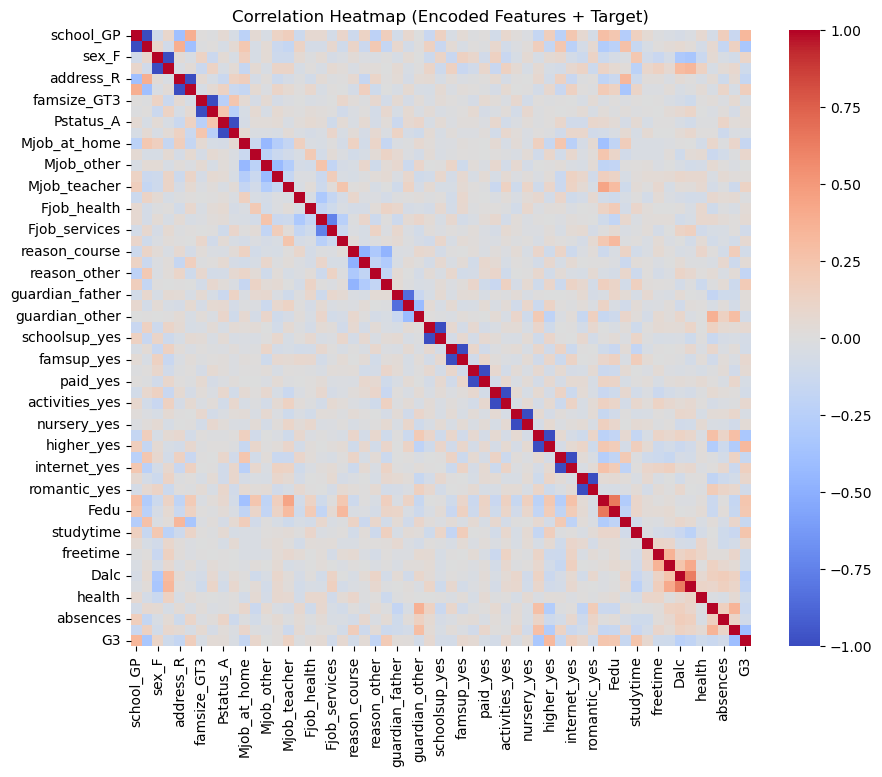

In [19]:
# ==============================================
# Step 6: Correlation Analysis
# ==============================================
# Combine encoded training features with target for correlation analysis
corr_df = pd.concat([X_train_enc, y_train], axis=1)

# Compute Pearson correlation matrix
corr_matrix = corr_df.corr(method='pearson')

# Extract correlation values between each feature and the target (G3)
target_corr = corr_matrix['G3'].sort_values(ascending=False)

# Display top 10 positive and negative correlations
print("Top 10 positive correlations with G3:")
print(target_corr.head(10))

print("\nTop 10 negative correlations with G3:")
print(target_corr.tail(10))

# Optional visualization: full heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Encoded Features + Target)")
plt.show()


### 7.Implement linear regression and report R2, and RMSE.

In [ ]:
# ==============================================
# Step 7: Linear Regression and metrics (R2, RMSE)
# ==============================================
# Ensure target is 1D
y_train_1d = np.asarray(y_train).ravel()
y_test_1d  = np.asarray(y_test).ravel()

# Fit model
linreg = LinearRegression()
linreg.fit(X_train_enc, y_train_1d)

# Predictions
y_pred_train = linreg.predict(X_train_enc)
y_pred_test  = linreg.predict(X_test_enc)

# R2
r2_train = r2_score(y_train_1d, y_pred_train)
r2_test  = r2_score(y_test_1d,  y_pred_test)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_1d, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_1d,  y_pred_test))

print(f"Train R2:   {r2_train:.4f}")
print(f"Test  R2:   {r2_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test  RMSE: {rmse_test:.4f}")

# Inspect top coefficients by absolute magnitude
coefs_abs = np.abs(linreg.coef_)
top_k = 15
top_idx = np.argsort(coefs_abs)[::-1][:top_k]
print("\nTop coefficients (abs):")
for i in top_idx:
    print(f"{X_train_enc.columns[i]:40s}  coef={linreg.coef_[i]: .5f}")


Train R2:   0.3874
Test  R2:   0.1602
Train RMSE: 2.5392
Test  RMSE: 2.8618

Top coefficients (abs):
failures                                  coef=-1.49866
higher_no                                 coef=-0.84347
higher_yes                                coef= 0.84347
schoolsup_no                              coef= 0.80170
schoolsup_yes                             coef=-0.80170
school_MS                                 coef=-0.69683
school_GP                                 coef= 0.69683
Fjob_at_home                              coef= 0.64189
Mjob_health                               coef= 0.60171
reason_other                              coef=-0.56562
Fjob_services                             coef=-0.45743
guardian_other                            coef= 0.45608
Mjob_at_home                              coef=-0.44317
reason_reputation                         coef= 0.43679
Fjob_health                               coef=-0.39921
